In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [40]:
# Load the Dataset
df = pd.read_csv("./../../Dataset/Final-dataset-vector/transformers.csv")

In [41]:
df["has_smells"] = df["has_smells"].apply(lambda x: list(map(int, x.strip("[]").split(","))))

                                  Absent (0)  Présent (1)
Scattered Functionality               257777        21187
Potential Improper API Usage          187643        91321
Potential Redundant Abstractions      272248         6716
Orphan Module                         278344          620
Unstable Dependency                   215463        63501
Hub-like Dependency                   278964            0
Cyclic Dependency                     278956            8
God Object                            268835        10129


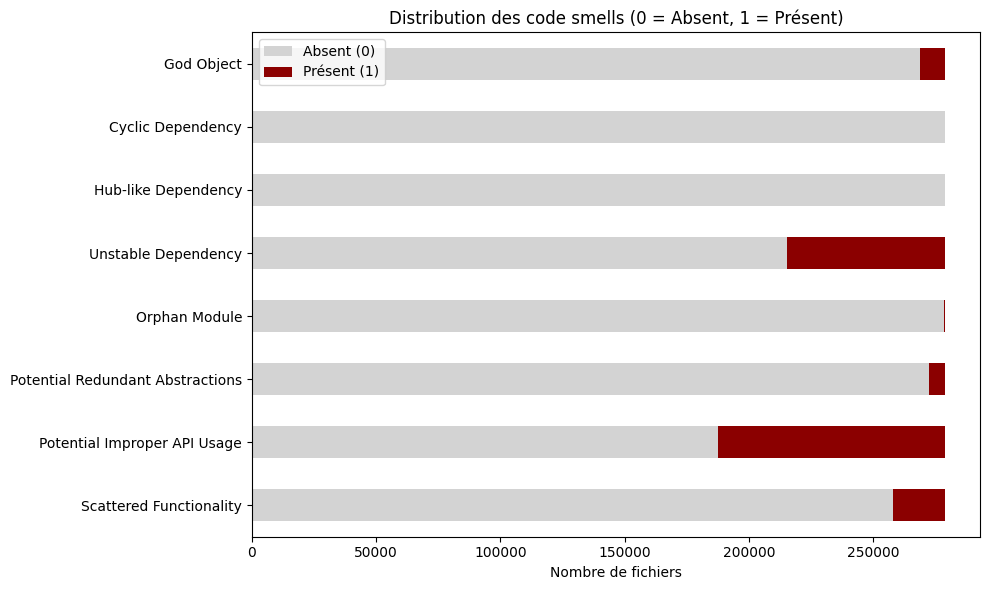

In [42]:
smell_labels = [
    "Scattered Functionality",
    "Potential Improper API Usage", 
    "Potential Redundant Abstractions",
    "Orphan Module",
    "Unstable Dependency",
    "Hub-like Dependency",
    "Cyclic Dependency",
    "God Object"
]

# Transformer la colonne en plusieurs colonnes
smells_df = pd.DataFrame(df["has_smells"].tolist(), columns=smell_labels)

# Afficher la distribution de 1 et 0 pour chaque smell
distribution = smells_df.apply(pd.Series.value_counts).T.fillna(0).astype(int)
distribution.columns = ['Absent (0)', 'Présent (1)']

# Affichage
print(distribution)

# Affichage graphique
distribution.plot(kind='barh', stacked=True, figsize=(10, 6), color=['lightgray', 'darkred'])
plt.xlabel("Nombre de fichiers")
plt.title("Distribution des code smells (0 = Absent, 1 = Présent)")
plt.tight_layout()
plt.show()

In [43]:
X = df[["line_count", "method_count", "coupling_score"]]
y = np.array(df["has_smells"].tolist())

In [44]:
# Splitting the dataset into the Training set and the Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Feature scaling - properly scale training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ANN Model

In [ ]:
def create_ann_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(3,)),  # 3 features: line_count, method_count, coupling_score
        Dense(32, activation='relu'),
        Dense(8, activation='sigmoid')  # 8 sorties pour les 8 labels
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
ann_model = KerasClassifier(model=create_ann_model, epochs=30, batch_size=16, verbose=0)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
ann_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[callback])

c:\Users\P2937574\architectural-smells-llm\tf_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,model,<function cre...001623AC07C70>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,16
,validation_batch_size,None
,verbose,0
,callbacks,None


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_ann = (ann_model.predict(X_test_scaled) > 0.5).astype(int)
print("Exact Match Accuracy:", accuracy_score(y_test, y_pred_ann))  # tous labels corrects = 1
print("Classification Report:\n", classification_report(y_test, y_pred_ann, target_names=smell_labels, zero_division=0))

for i, label in enumerate(smell_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_ann[:, i])
    print(f"Confusion Matrix for {label}:\n{cm}\n")

Exact Match Accuracy: 0.6300252719875253
Classification Report:
                                   precision    recall  f1-score   support

         Scattered Functionality       0.75      0.05      0.09      4239
    Potential Improper API Usage       0.71      0.75      0.73     18210
Potential Redundant Abstractions       0.00      0.00      0.00      1326
                   Orphan Module       0.82      1.00      0.90       116
             Unstable Dependency       0.71      0.43      0.54     12767
             Hub-like Dependency       0.00      0.00      0.00         0
               Cyclic Dependency       0.00      0.00      0.00         4
                      God Object       0.71      0.17      0.27      2026

                       micro avg       0.71      0.51      0.60     38688
                       macro avg       0.46      0.30      0.32     38688
                    weighted avg       0.69      0.51      0.55     38688
                     samples avg       0.26  

c:\Users\P2937574\architectural-smells-llm\tf_env\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Random Forest Model

In [50]:
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = MultiOutputClassifier(rf_base)

In [ ]:
rf_model.fit(X_train_scaled, y_train)
y_pred_forest = rf_model.predict(X_test_scaled)

In [52]:
# Évaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Exact Match Accuracy (RF):", accuracy_score(y_test, y_pred_forest))
print("Classification Report (RF):\n", classification_report(y_test, y_pred_forest, target_names=smell_labels, zero_division=0))

# Confusion matrix par label
for i, label in enumerate(smell_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_forest[:, i])
    print(f"Confusion Matrix for {label}:\n{cm}\n")

Exact Match Accuracy (RF): 0.8931586399727565
Classification Report (RF):
                                   precision    recall  f1-score   support

         Scattered Functionality       0.91      0.82      0.86      4239
    Potential Improper API Usage       0.93      0.91      0.92     18210
Potential Redundant Abstractions       0.81      0.48      0.60      1326
                   Orphan Module       0.82      1.00      0.90       116
             Unstable Dependency       0.92      0.88      0.90     12767
             Hub-like Dependency       0.00      0.00      0.00         0
               Cyclic Dependency       0.00      0.00      0.00         4
                      God Object       0.78      0.89      0.83      2026

                       micro avg       0.91      0.87      0.89     38688
                       macro avg       0.65      0.62      0.63     38688
                    weighted avg       0.91      0.87      0.89     38688
                     samples avg   

c:\Users\P2937574\architectural-smells-llm\tf_env\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


# Code Stacking (SVR)

In [ ]:
# Create base models for stacking (without MultiOutputClassifier wrapper)
rf_base_for_stacking = RandomForestClassifier(n_estimators=100, random_state=42)

estimators = [
    ('ann', ann_model),
    ('rf', rf_base_for_stacking)
]

In [54]:
# Logistic Regression en méta-apprenant (SVR remplacé car incompatible)
meta_model = LogisticRegression(max_iter=1000)

In [55]:
stacking_base = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5
)

In [56]:
stacking_model = MultiOutputClassifier(stacking_base)

In [ ]:
print(y_train.shape)
print(np.unique(y_train))

print("🔁 Entraînement du modèle empilé...")
stacking_model.fit(X_train_scaled, y_train)

(223171, 8)
[0 1]
🔁 Entraînement du modèle empilé...


c:\Users\P2937574\architectural-smells-llm\tf_env\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 8)

In [ ]:
y_pred = stacking_model.predict(X_test_scaled)

In [ ]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
print("MSE du modèle de stacking (SVR):", mse)
print("Prédictions (extrait):", y_pred[:10])

MSE du modèle de stacking (SVR): 0.10344769392888369
Prédictions (extrait): [0.90029503 0.90029527 0.10048863 0.10036142 0.10037865 0.10312759
 0.46954194 0.10056162 0.90029445 0.90029455]


In [ ]:
final_preds_binary = (y_pred >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, final_preds_binary)
print("Accuracy stacking SVR :", accuracy)

# Evaluation complète
print("Confusing Maxtric:\n", confusion_matrix(y_test, final_preds_binary))
print("Classification Report:\n", classification_report(y_test, final_preds_binary))

Accuracy stacking SVR : 0.8785907859078591
Confusing Maxtric:
 [[24206  1980]
 [ 4068 19561]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     26186
           1       0.91      0.83      0.87     23629

    accuracy                           0.88     49815
   macro avg       0.88      0.88      0.88     49815
weighted avg       0.88      0.88      0.88     49815

